<a href="https://colab.research.google.com/github/paton838/works/blob/master/share_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# inspired by https://www.youtube.com/watch?v=QIUxPv5PJOY
# with added functions to predict the future few days, and with different optimizers
%tensorflow_version 1.x
import math
import numpy as np
import pandas as pd

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
import datetime as dt
from datetime import datetime

In [0]:
# name of the share to be predicted
share_name = 'AIR.NZ'

In [242]:
# read in data
df = web.DataReader(share_name, data_source='yahoo', start='2005-01-01', end='2020-04-16')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-04,1.65,1.63,1.64,1.65,123600.0,0.639172
2005-01-05,1.65,1.63,1.65,1.63,167100.0,0.631424
2005-01-06,1.63,1.62,1.63,1.63,39800.0,0.631424
2005-01-09,1.63,1.62,1.63,1.63,703100.0,0.631424
2005-01-10,1.63,1.62,1.63,1.62,149800.0,0.627550


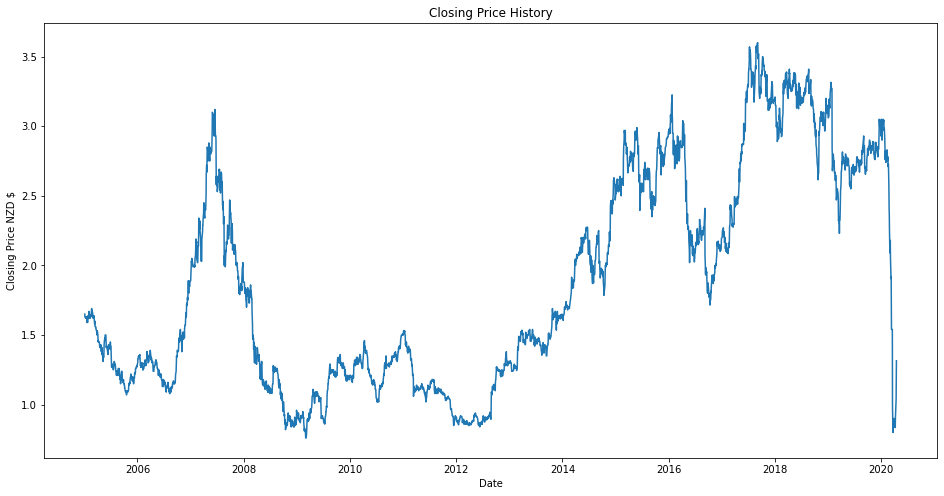

In [243]:
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price NZD $')
plt.show()

In [244]:
# get the Closing price column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

3076

In [247]:
# scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# scaled_data

array([[0.31338029],
       [0.30633804],
       [0.30633804],
       ...,
       [0.09859154],
       [0.14788731],
       [0.19542256]])

In [0]:
# use past 100 days to see the trend
n_days_use = 100

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

# append each set of 'n_days_use' into x_train
for i in range(n_days_use, len(train_data)):
  x_train.append(train_data[i-n_days_use:i, 0])
  y_train.append(train_data[i, 0])

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [261]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2976, 100, 1)

In [0]:
# train model. best result = 0.08279703697189689
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(x_train, y_train, batch_size=1, epochs=1)

In [239]:
# train model. best result = 0.059735862305387855
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2976/2976 [==============================] - 190s 64ms/step - loss: 0.0015


In [227]:
# # train model. best result = 0.07695954650019605
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adamax', loss='mean_squared_error')
# model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2976/2976 [==============================] - 196s 66ms/step - loss: 9.9912e-04


In [0]:
# get the sets of 'n_days_use' to test
test_data = scaled_data[training_data_len - n_days_use: , :]

x_test = []
y_test = dataset[training_data_len: , :]
for i in range(n_days_use, len(test_data)):
  x_test.append(test_data[i-n_days_use:i, 0])

In [0]:
x_test = np.array(x_test)

In [0]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
# predict share price
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [270]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.059735862305387855

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


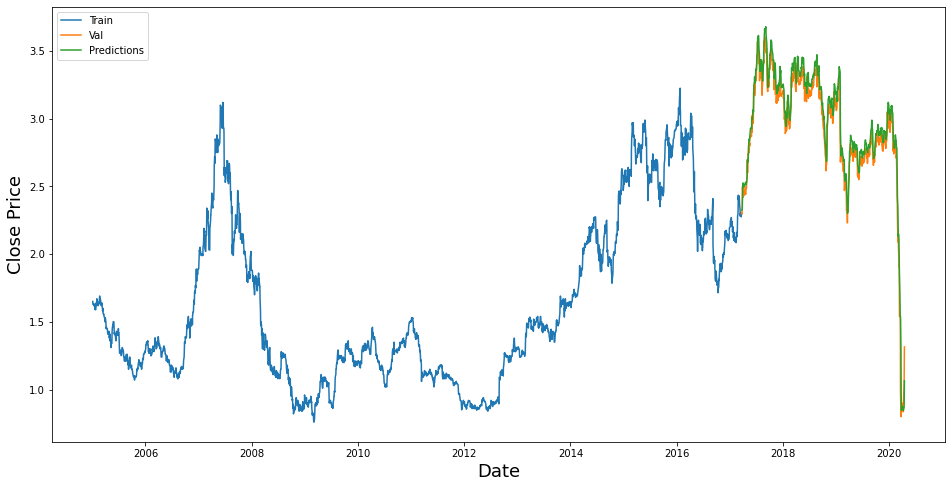

In [273]:
# plot to show the prediction and actual price

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [274]:
valid.sample(5)

,Close,Predictions
Date,,
2018-03-26,3.320,3.405773
2018-06-24,3.195,3.341189
2018-05-21,3.375,3.449935
2018-06-06,3.215,3.263086
2019-01-23,3.280,3.383730


In [0]:
# get the the quote
# quote = web.DataReader(share_name, data_source='yahoo', start='2005-01-01', end='2020-04-16')
quote = df

In [0]:
#Create a new dataframe
new_df = quote.filter(['Close'])

def predict_(df):
  # #Get the last n day closing price values and convert the dataframe to an array
  last_n_days = df[-n_days_use:].values

  #Scale the data to be values between 0 and 1
  last_n_days_scaled = scaler.transform(last_n_days)
  #Create an empty list
  X_test = []
  #Append the past n days
  X_test.append(last_n_days_scaled)
  #Convert the X_test data set to a numpy array
  X_test = np.array(X_test)

  #Reshape the data
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  #Get the predicted scaled price
  pred_price = model.predict(X_test)

  #undo the scaling 
  pred_price = scaler.inverse_transform(pred_price)

  return pred_price

In [0]:
def print_ht(df, num):
  print(df.head(num))
  print(df.tail(num))

In [0]:
# get the value in prediction
def get_prediction_value(df_to_predict):
  return predict_(df_to_predict)[0][0]

In [0]:
# append new data to the df, with n_days of future days to be predicted
def predict_append(df_a, n_days):
  turn0_index = -1
  turn0_date = ''
  for i in range(n_days+1):
    # print_ht(temp_df, 3)

    # get new prediction
    new_prediction = get_prediction_value(df_a)

    # get the date of the next date
    next_date = pd.to_datetime( df_a.index[-1] + timedelta(days=1) ).date()
    # print(f'New date: {next_date}. Predicted price: {new_prediction}. ')

    # update df_a
    new_row = pd.DataFrame({'Close': new_prediction}, index=pd.to_datetime([next_date]))
    df_a = df_a.append(new_row)
    if (new_prediction <= 0) & (turn0_index == -1):
      turn0_index = i
      turn0_date = next_date
      # print(f'Turn 0 here::: Index: {turn0_index}, Date: {turn0_date}')
  return {'data':df_a, 'turn0': [turn0_index, turn0_date]}

In [293]:
# try predicting the next 5 days
days_to_predict = 5

predicted_future = predict_append(new_df, days_to_predict)
predicted_days = ( predicted_future )['data'].iloc[-days_to_predict:, :]

print(predicted_days.head(6))
print(predicted_days.shape)
print(f'Date turn 0: {predicted_future["turn0"][0]}, {predicted_future["turn0"][1]}')

               Close
2020-04-17  1.240727
2020-04-18  1.257284
2020-04-19  1.269832
2020-04-20  1.282030
2020-04-21  1.294081
(5, 1)
Date turn 0: -1, 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


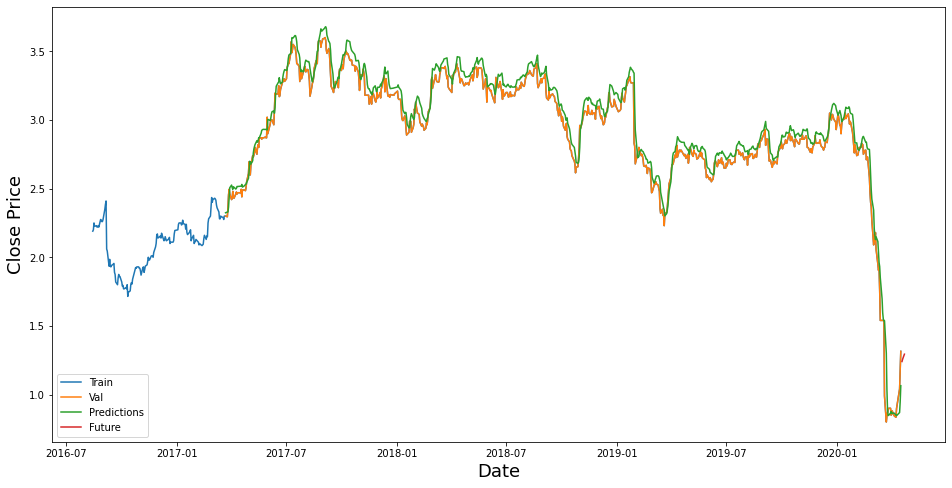

In [294]:
# only show the latest 5% of the training (past) data
train = data[math.ceil(training_data_len*0.95):]
valid = data[training_data_len:]

valid['Predictions'] = predictions


future = predicted_days

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(future['Close'])

## if the predicted price goes below 0
# plt.annotate(f'Turn 0 @{predicted_future["turn0"][1]}!', xy=[predicted_future["turn0"][1], 0]
#               , xytext=(pd.Timestamp('2019-01-01'), 0.5)
#               , arrowprops={'arrowstyle':'->', 'color':'red'})

plt.legend(['Train', 'Val', 'Predictions', 'Future'], loc='lower left')
plt.show()

In [295]:
# the predicted price of the next few days
future

,Close
2020-04-17,1.240727
2020-04-18,1.257284
2020-04-19,1.269832
2020-04-20,1.282030
2020-04-21,1.294081


In [296]:
# the actual price of the last few days
quote2 = web.DataReader(share_name, data_source='yahoo', start='2020-04-07', end='2020-04-16')
print(quote2['Close'])

Date
2020-04-06    0.850
2020-04-07    0.835
2020-04-08    0.900
2020-04-13    1.040
2020-04-14    1.180
2020-04-15    1.315
Name: Close, dtype: float64
